# Analyzing a Fortran Stencil Program

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Understanding

Open the <tt>stencil2d-orig.F90</tt> Fortran program by double clicking on the file in the File Browser on the left (if it is hidden, click on the Folder icon).

![open-stencil2d](img/open-stencil2d.png)

If you prefer, you can also open a new Terminal (File -> New -> Terminal), navigate to the location where <tt>stencil2d-orig.F90</tt> is located and use your favorite linux editor (e.g. vim) to browse the Fortran source code. This will give you better syntax highlighting.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Read the code of <tt>stencil2d-orig.F90</tt> and understand what the program is doing. If you are new to Fortran programming, take a look <a href="https://ourcodingclub.github.io/tutorials/fortran-intro/">here</a> for a brief introduction.<br>
<b>2.</b> Compile the code and run it (see below).<br><br>

<i>Note 1:</i> The Jupyter notebook cells which start with the <code>%%bash</code> command are not Python code. They contain commands that you would otherwise type into a terminal. If you are unfamiliar with this, give it a try! Create a new cell which starts with <code>%%bash</code> and put a linux command in the cell (e.g. <code>ls</code>). This is very convenient for executing shell commands in a Python notebook. If you want to read more about this, take a look at the <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-script">documentation</a> (note that <code>%%bash</code> is a shorthand for <code>%%script bash</code>).<br><br>
<i>Note 2:</i> A similar technique is to use the <code>!</code> to execute a shell command. This is typically used to capture the output of a shell command for further processing.<br><br>
<i>Note 3:</i> The <tt>make</tt> command is a standard linux tool that eases the burden of compiling a program. It relies on a <tt>Makefile</tt> which contains instructions of how to build a <i>target</i>. Our <tt>Makefile</tt> is written in a way that we can conveniently compile multiple versions of the <tt>stencil2d-</tt><i>version</i><tt>.F90</tt> program. The standard output of the cell shows which commands are actually executed to compile our program. The actual compilation is of the form <code>ftn <i>[-option] name</i>.F90</code>.<br>
</div>

## Compiling

On Piz Daint, the programming environment is managed using so called modules. We need to load the right modules in order to compile our program. We are going to use the Cray Fortran compiler (<tt>PrgEnv-cray</tt>) for this exercise. (Note: If we are using <tt>%%bash</tt> cell magic, these commands need to be repeated every time to setup the right environment.

In [2]:
%%bash
echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
make VERSION=orig

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-orig.F90
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x


## Running

We can run our program on all 72 cores of the Grace Hopper CPU that we have available using the <tt>srun</tt> command. The command line arguments <tt>nx, ny, nz</tt> specify the size of the computational domain and <tt>num_iter</tt> sets the number of iterations (timesteps).

In [3]:
output = !srun -n 72 ./stencil2d-orig.x --nx 128 --ny 128 --nz 64 --num_iter 1024

The output of the Fortran program is stored in the `output` variable. We can examine the result. Since the output of the Fortran program is already in a format that is understandable by Python, we can also execute the code contained in the string to define `data`.

In [4]:
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   72,  128,  128,   64,    1024,  0.7222568E+01], \
] )


We now have the output of the `stencil2d-orig.F90` program in a data structure named `data` in our notebook. As you can see above, it contains the number of cores we ran on `ranks` (12), the size of the computational domain `nx` (128), `ny` (128), `nz` (64), the number of iterations `num_iter` (1024) and the actual runtime in seconds (approx. 7 s).

In [5]:
print(data)

[[  72.        128.        128.         64.       1024.          7.222568]]


The Fortran program writes two data files (`in_field.dat` and `out_field.dat`) which contain the initial condition as well as the resulting field at the end of the iterations. We can load the data into Python in order to visually verify that our stencil program is actually applying diffusion. We show only the lowest level (`k=0`) in the images.

In [6]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

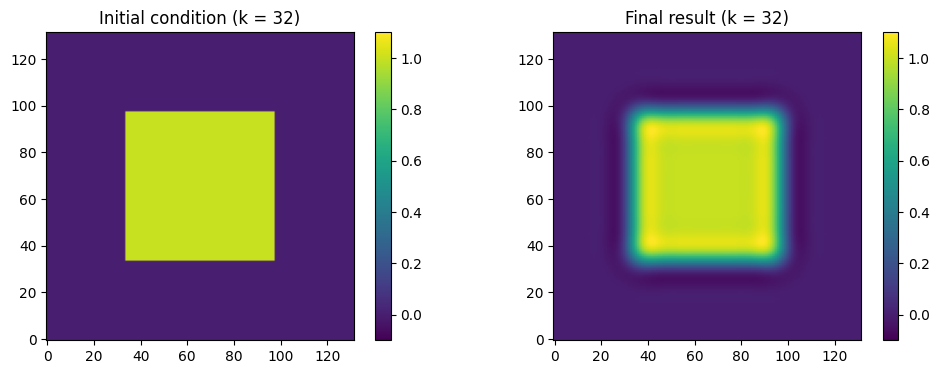

In [7]:
validate_results()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Play around a bit with the above program. Change the number of iterations to 1 and run again (you do not need to compile again!) and make a visualization of the result after only 1 iteration. Change back to 1024 iterations and change the size of the domain to <tt>nx=ny=64</tt> and give it a spin. How does the runtime change when you reduce the computational domain by a factor of 4x? Feel free to explore more and get comportable with the Fortran program...<br>
<b>4.</b> There is another version of the stencil program named <tt>stencil2d-counters.F90</tt> where we have introduced two global variables of type <tt>integer</tt> named <tt>flop_counter</tt> and <tt>byte_counter</tt>. The goal of this exercise is to manually count the number of floating point operations and amount of memory transfers directly in the code inside the loops where the work is happening. Edit the program to count the number of floating-point operations and bytes transferred to/from memory. Compile and run. <i>(Hint: The places where you need to make edits are marked with TODO in the code and a first example is given.)</i><br>
<b>5.</b> Compile and run the <tt>stencil2d-counters.F90</tt> program. The flop and byte count will appear in the standard output as additional entries into the <tt>data</tt> array. Make sure that the runtime is still approximately the same as before and that the introduction of the counters did not impact the runtime too negatively. Also validate the program is still correct by visualizing the results using <tt>validate_results()</tt>.<br>
</div>

In [8]:
%%bash
make VERSION=counters

mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-counters.F90
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x


In [9]:
output = !srun -n 72 ./stencil2d-counters.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [10]:
print(output.nlstr)
exec(output.nlstr)
print(data)

# ranks nx ny nz num_iter time flop byte
data = np.array( [ \
[   72,  128,  128,   64,    1024,  0.7655534E+01,  0.9398869E+12,  0.5354130E+13], \
] )
[[7.200000e+01 1.280000e+02 1.280000e+02 6.400000e+01 1.024000e+03
  7.655534e+00 9.398869e+11 5.354130e+12]]


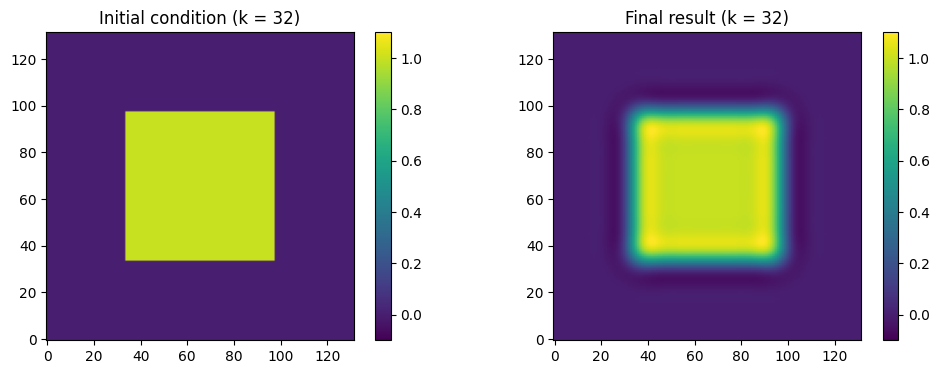

In [11]:
validate_results()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Using the flop and byte counts stored in <tt>data</tt>, compute the arithmetic intensity $I$ of our stencil program.<br>
<b>7.</b> Compute the performance in GFLOP/s of our stencil program. Is our program memory bound or compute bound? Which % of peak FLOP/s and memory bandwidth do we achieve? Do you trust these estimations?<br>
</div>

In [12]:
gflop_counter = data[0, 6] / 1.0E9 # TODO
gb_counter = data[0, 7] / 1.0e9 # TODO
arithmetic_intensity = gflop_counter / gb_counter # TODO
print("gflop_counter = {}".format(gflop_counter))
print("gb_counter = {}".format(gb_counter))
print("Arithmetic intensity = {}".format(arithmetic_intensity))

gflop_counter = 939.8869
gb_counter = 5354.13
Arithmetic intensity = 0.1755442807701718


In [13]:
runtime = data[0, 5] # TODO
peak_bandwidth_in_gbs = 512.0 # TODO
peak_performance_in_gflops = 3991.68 # TODO
performance_in_gflops = gflop_counter / runtime # TODO
bandwidth_in_gbs = gb_counter / runtime # TODO
performance_percent_peak = performance_in_gflops / peak_performance_in_gflops * 100. # TODO
bandwidth_percent_peak = bandwidth_in_gbs / peak_bandwidth_in_gbs * 100. # TODO
print("runtime {}".format(runtime))
print("GFLOP/s = {} ({:6.3f}% theoretical peak)".format(performance_in_gflops, performance_percent_peak))
print("GB/s = {} ({:6.3f}% theoretical peak)".format(bandwidth_in_gbs, bandwidth_percent_peak))

runtime 7.655534
GFLOP/s = 122.77221941669907 ( 3.076% theoretical peak)
GB/s = 699.380343683406 (136.598% theoretical peak)


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>8.</b> Run the stencil program for different <tt>nx</tt> and <tt>ny</tt> (using the <tt>--scan</tt> option, see below). Import the data into a Python notebook and make a loglog-plot of the runtime per gridpoint $r = \mathrm{runtime} \, / \, nx \, / \, ny \, / nz$ in $\mu s$ versus the working set size $\mathrm{work\_size} = nx \times ny \times nz \times 3 \times 4 \, \mathrm{Bytes}$ in MB. How would you expect this plot to look like for a von Neumann architecture? What might be the reason that the behavior is different?<br><br> 

<i>Note:</i> Running with the <tt>--scan</tt> will take some time to complete. Be patient! If you want more precise numbers and you have the patience, try generating this plot with 1024 iterations instead of 128.<br>
</div>

In [14]:
output = !srun -n 72 ./stencil2d-orig.x --scan --nz 64 --num_iter 128

In [15]:
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   72,   16,   16,   64,     128,  0.2531626E-02], \
[   72,   32,   16,   64,     128,  0.4435086E-02], \
[   72,   48,   16,   64,     128,  0.6631048E-02], \
[   72,   64,   16,   64,     128,  0.9379251E-02], \
[   72,   96,   16,   64,     128,  0.1640618E-01], \
[   72,  128,   16,   64,     128,  0.2848048E-01], \
[   72,  192,   16,   64,     128,  0.7054023E-01], \
[   72,   16,   32,   64,     128,  0.4806457E-02], \
[   72,   32,   32,   64,     128,  0.9010197E-02], \
[   72,   48,   32,   64,     128,  0.1436166E-01], \
[   72,   64,   32,   64,     128,  0.2001112E-01], \
[   72,   96,   32,   64,     128,  0.3855248E-01], \
[   72,  128,   32,   64,     128,  0.7834858E-01], \
[   72,  192,   32,   64,     128,  0.1440413E+00], \
[   72,   16,   48,   64,     128,  0.7140310E-02], \
[   72,   32,   48,   64,     128,  0.1405650E-01], \
[   72,   48,   48,   64,     128,  0.2243424E-01], \
[   72,   64,   48,   64,     

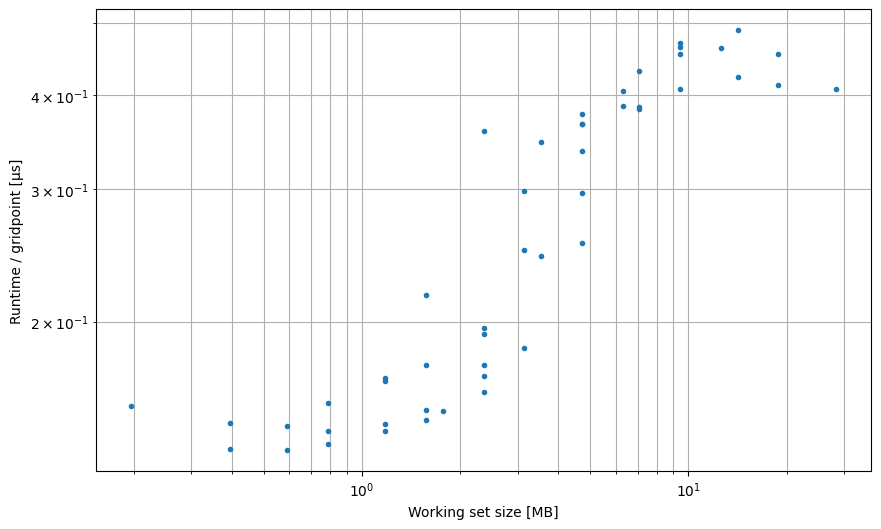

In [16]:
work_size = data[:, 1] * data[:, 2] * data[:, 3] * 3 * 4 # TODO
runtime_per_gridpoint = data[:, 5] / data[:, 1] / data[:, 2] / data[:, 3] # TODO
plt.loglog( work_size / 1.0e6, runtime_per_gridpoint * 1.0e6 , '.');
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(visible=True, which='both')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

## Performance Analysis Tool (perf stat)

We can also use a performance analysis tool named <tt>perf</tt> to analyze the performance of our stencil program (see [the manpage of perf](https://man7.org/linux/man-pages/man1/perf.1.html) for more information. Our program does not need to be re-compiled for performance analysis with <tt>perf</tt>. Using the command<p><p>
<tt>perf stat -e mem_access_rd,mem_access_wr,l2d_cache_refill_rd,l2d_cache_refill_wr \<executable\> \<options\></tt><p><p>
we can run any executable. The arguments after the <tt>-e</tt> option list the specific hardware counters we would like to collect. In this example, we are specifically interested in collecting the total number of memory read and write transactions <tt>mem_access_rd, mem_access_wr</tt>) as well as the number of system memory read and write transactions (<tt>l2d_cache_refill_rd, l2d_cache_refill_wr</tt>).

Since we run our program on all cores of the Grace CPU and this would lead to unreadable output, we have provided a convenience shell-script (<tt>perf_wrap.sh</tt>) which deals with running the <tt>perf stat</tt> command and capturing the output inside the directory "perf". We also provide a convenience function in Python to parse and process the performance analysis output.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> Run your program with counters using <tt>perf</tt> performance analysis tool (see below). Inspect one of the reports generated by <tt>perf</tt> (written to the file <tt>perf/00000.txt</tt>).<br>
<b>10.</b> Compare the memory transfer numbers against your values. By which factor are you off? What could be the reason?<br>
<b>11.</b> Run again with $nx = 32$ and $ny = 32$. Did the factor by which you are off change? Is this consistent with the findings above? Do you have an idea why this might be the case?<br>
</div>

In [17]:
# this is a utility function we will need below for parsing the performance analysis output
import re
import numpy as np
from pathlib import Path
from typing import Tuple

def parse_perf_stat(directory: Path = Path('./perf/')):
    mem_rd_values = []
    mem_wr_values = []
    l2_rd_values = []
    l2_wr_values = []

    for perf_file in sorted(directory.glob("?????.txt")):
        with perf_file.open() as f:
            lines = f.readlines()

            for line in lines:
                if 'mem_access_rd' in line:
                    mem_rd_values.append(int(line.strip().split()[0].replace(',', '')))
                elif 'mem_access_wr' in line:
                    mem_wr_values.append(int(line.strip().split()[0].replace(',', '')))
                elif 'l2d_cache_refill_rd' in line:
                    l2_rd_values.append(int(line.strip().split()[0].replace(',', '')))
                elif 'l2d_cache_refill_wr' in line:
                    l2_wr_values.append(int(line.strip().split()[0].replace(',', '')))

    total_accesses = float(np.array(mem_rd_values).mean()) + float(np.array(mem_wr_values).mean())
    total_l3_accesses = float(np.array(l2_rd_values).mean()) + float(np.array(l2_wr_values).mean())
    return (total_l3_accesses * 64, total_accesses * 4)


In [18]:
%%bash
make clean
make VERSION=counters

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-counters.F90
mpif90  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x


In [19]:
%%bash
echo "====== 128 x 128 x 64 ======"
srun -n 72 perf_wrap.sh ./stencil2d-counters.x --nx 128 --ny 128 --nz 64 --num_iter 1024

====== 128 x 128 x 64 ======
# ranks nx ny nz num_iter time flop byte
data = np.array( [ \
[   72,  128,  128,   64,    1024,  0.3660284E+01,  0.9398869E+12,  0.5354130E+13], \
] )


In [20]:
total_system_memory_accesses_Bytes_per_core, total_memory_accesses_Bytes_per_core = parse_perf_stat()

total_number_of_measured_GB = total_system_memory_accesses_Bytes_per_core * 72 / 1e9 # TODO
total_number_of_counted_GB = 0.5354130E+13 / 1e9 # TODO

print("Total memory access measured = {} GB".format(total_number_of_measured_GB))
print("Total memory access counted = {} GB".format(total_number_of_counted_GB))

Total memory access measured = 386.455311168 GB
Total memory access counted = 5354.13 GB


In [21]:
%%bash
echo "====== 32 x 32 x 64 ======"
srun -n 72 perf_wrap.sh ./stencil2d-counters.x --nx 32 --ny 32 --nz 64 --num_iter 1024

====== 32 x 32 x 64 ======
# ranks nx ny nz num_iter time flop byte
data = np.array( [ \
[   72,   32,   32,   64,    1024,  0.7456270E-01,  0.6109633E+11,  0.3537434E+12], \
] )


In [22]:
total_system_memory_accesses_Bytes_per_core, total_memory_accesses_Bytes_per_core = parse_perf_stat()

total_number_of_measured_GB = total_system_memory_accesses_Bytes_per_core * 72 / 1e9 # TODO
total_number_of_counted_GB = 0.3537434E+12 / 1e9 # TODO

print("Total memory access measured = {} GB".format(total_number_of_measured_GB))
print("Total memory access counted = {} GB".format(total_number_of_counted_GB))

Total memory access measured = 4.955568832 GB
Total memory access counted = 353.7434 GB


In [23]:
# TODO
#
# Running at nx=128 ny=128 nz=64 and num_iter=1024 we have 5354 GB from the counters
# and perf stat reports 389 GB, that's only 7.3% of our estimate from the counters.
#
# Running at nx=32 ny=32 nz=64 and num_iter=1024 we have 354 GB from the counters
# and perf stat reports 4.8 GB, that's only 1.4% of our estimate from the counters.
#
# The reason for the large discrepancy between measured and counted is that the compiler
# probably optimizes the code such that memory accesses are replaced with register accesses.
#
# The reason for the much smaller fraction of actual system memory transfer for smaller domains
# is because information is retained in what are called memory caches, so that they don't have
# to be re-read from system memory.
#
# We have 1.6 MB of L3 cache per core. A float32 field occupies 4 MB for
# nx x ny x nz = 128 x 128 x 64 and 0.25 MB for nx x ny x nz = 32 x 32 x 64.
# We have 3 fields in the code (in_field, tmp_field, out_field).
# In the first case we do not fit into L3 cache. In the second case, we easily fit into L3
# cache and only have to read the fields once, after that they can be read from / written to in cache.

In [24]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
